In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from pprint import pprint
import urllib.request

In [ ]:
!pip install attention
from attention import AttentionLayer

In [7]:
url = "https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py"
urllib.request.urlretrieve(url, filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x7febd38f1f90>)

In [8]:
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

In [107]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

In [10]:
from google.colab import drive

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [13]:
!ls -l

total 20
-rw-r--r-- 1 root root 4645 Apr  2 04:19 attention.py
drwx------ 5 root root 4096 Apr  2 04:19 drive
drwxr-xr-x 2 root root 4096 Apr  2 04:19 __pycache__
drwxr-xr-x 1 root root 4096 Mar 25 13:38 sample_data


In [16]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/data/Reviews.csv' , nrows = 100000)

## 1. Data Load

In [17]:
print('전체 리뷰 개수: ' , len(data))

전체 리뷰 개수:  100000


In [18]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [19]:
data.keys()

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### 1) test, summary 분리

In [20]:
data = data[['Text' , 'Summary']]

data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [21]:
data.sample(10)

,Text,Summary
10613,Gimme better ingredients (KIND/Larabars) for m...,Slightly healthier but not worth it
66257,These fenugreek seeds were very fresh when the...,Quite fresh
17199,"These are great, the perfect mix of coconut an...","Great snack for the kids, and I sneak a few too"
50432,i order these for my baby shower and unfortuna...,never again.!!
95619,"These are great - very light and crispy, and n...",Perfect potato chips!
21417,"I don't write too many reviews, but I read the...",My Dog Goes CRAZY!!
34222,I have been using C.E.T chews for my dog for m...,C.E.T.Chews
35261,My 5 month old aussie/border collie mix puppy ...,Fun game for dogs
62847,I'm giving this product three stars by grading...,Chocolate?
71447,I received a free sample and I was hooked on f...,ADDICTINGLY YUMMY


## 2. Data Preprocessing

### 1) 불필요한 샘플 제거

- 중복샘플이 있는지 확인

In [22]:
print(data['Text'].nunique() , data['Summary'].nunique())

88426 72348


- 중복인 내용 제거

In [23]:
data.drop_duplicates(subset = ['Text'] , inplace = True)
print('전체 샘플수: ' , len(data))

전체 샘플수:  88426


- Null 샘플 존재 확인

In [24]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [25]:
# Null이 존재할 경우
data.dropna(axis = 0, inplace = True)

### 2) 샘플 내부 전처리

- 동일한 의미지만 스펠링이 다른 단어 정규화
- 참고링크: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [26]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                "'cause": "because", "could've": "could have", 
                "couldn't": "could not", "didn't": "did not", 
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                "hasn't": "has not", "haven't": "have not", "he'd": "he would",
                "he'll": "he will", "he's": "he is", "how'd": "how did", 
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                "I'll've": "I will have","I'm": "I am", "I've": "I have",
                "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                "it'll": "it will", "it'll've": "it will have","it's": "it is",
                "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                "might've": "might have","mightn't": "might not",
                "mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have",
                "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", 
                "oughtn't've": "ought not have", "shan't": "shall not", 
                "sha'n't": "shall not", "shan't've": "shall not have", 
                "she'd": "she would", "she'd've": "she would have", 
                "she'll": "she will", "she'll've": "she will have", 
                "she's": "she is", "should've": "should have",
                "shouldn't": "should not", "shouldn't've": "should not have", 
                "so've": "so have","so's": "so as", "this's": "this is",
                "that'd": "that would", "that'd've": "that would have", 
                "that's": "that is", "there'd": "there would", 
                "there'd've": "there would have", "there's": "there is", 
                "here's": "here is","they'd": "they would", 
                "they'd've": "they would have", "they'll": "they will",
                "they'll've": "they will have", "they're": "they are", 
                "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", 
                "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will",
                "what'll've": "what will have", "what're": "what are", 
                "what's": "what is", "what've": "what have", "when's": "when is",
                "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", 
                "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have",
                "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", 
                "wouldn't've": "would not have", "y'all": "you all", 
                "y'all'd": "you all would","y'all'd've": "you all would have",
                "y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", 
                "you'll": "you will", "you'll've": "you will have", 
                "you're": "you are", "you've": "you have"}

- NLTK의 불용어를 저장하고 개수 확인

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수: ' , len(stop_words))
print('불용어 종류: ' , stop_words)

불용어 개수:  179
불용어 종류:  {'in', 'weren', 'up', 'of', 'than', 'we', 'they', 'further', "you've", 'off', 'o', 'shouldn', 'no', 'y', 'if', "shan't", 'nor', 'other', 'will', 'does', 'not', 'is', 'have', 'this', 'over', "couldn't", 'ourselves', 'some', 'mightn', 'm', 'a', "shouldn't", 'which', 'herself', "that'll", "you'd", 'between', 'my', "you'll", "wouldn't", "she's", 'haven', 'are', 'very', 'ma', 'from', 'who', "don't", 'itself', 've', 'below', 'where', "won't", 'each', 'by', 'having', 'these', 'while', 'with', 'through', 'before', 'myself', "mightn't", 'hers', 'do', 'doing', 'can', 'then', 'now', 'll', 't', "mustn't", "hasn't", "should've", "it's", 'such', 'hadn', 'out', "wasn't", 'she', 'themselves', 're', 'its', 'yours', 'when', 'an', 'whom', 'has', 'his', 'own', 'her', 'to', 'wouldn', 'most', 'any', 'here', 'just', 'our', 'ours', "you're", 'too', 'shan', 'what', 'there', 'for', 'above', 'that', 'and', 'why', 'their', "aren't", 'hasn', 'me', 'as', 'needn', 'your', 'him', 'them', 'on', '

### 3) 전처리 함수 설계

In [29]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True) :
  sentence = sentence.lower()

  # <br /> <a ref = ...> 등의 html 태그 제거
  sentence = BeautifulSoup(sentence, "lxml").text
  # 괄호로 닫힌 문자열 제거 ex) my husband (and myself) for => my husband for
  sentence = re.sub(r'\([^)]*\)' , '' , sentence)
  # 쌍따옴표 제거
  sentence = re.sub('"' , '' , sentence)
  # 약어 정규화
  sentence = ' '.join([contractions[t] if t in contractions else t
                       for t in sentence.split(" ")]) 
  # 소유격 제거 ex) roland's => roland
  sentence = re.sub(r"'s\b" , '' , sentence)
  # 영어 외 문자(숫자, 특수문자 등) 공백으로 전환
  sentence = re.sub("[^a-zA-Z]" , " " , sentence)
  # m이 3개 이상이면 2개로 변경 ex) ummmmmmm yeah => umm yeah
  sentence = re.sub('m]{2,}' , 'mm' , sentence)
  # 불용어 제거(Text)
  if remove_stopwords:
    tokens = ' '.join(word for word in sentence.split()
    if not word in stop_words if len(word) > 1)
  # 불용어 미제거(Summary)
  else:
    tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
  
  return tokens

- 함수 테스트

In [30]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = "Great way to start aren't (or finish) the day!!! ummmmm"
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start are not the day ummmmm


### 4) Text열 전처리

In [31]:
clean_text = []

for s in data['Text'] :
  clean_text.append(preprocess_sentence(s))

clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

### 5) Summary 열 전처리

In [32]:
clean_summary = []

for s in data['Summary'] :
  clean_summary.append(preprocess_sentence(s, 0))

clean_summary[:5]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [33]:
data['Text'] = clean_text
data['Summary'] = clean_summary

### 6) 전처리과정에서 생긴 공백 처리
- Null 값으로 변환

In [34]:
data.replace('' , np.nan, inplace = True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


- Null 제거

In [35]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수: ' , len(data))

전체 샘플수:  88355


### 7) 길이분포 확인

텍스트의 최소 길이: 2 
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


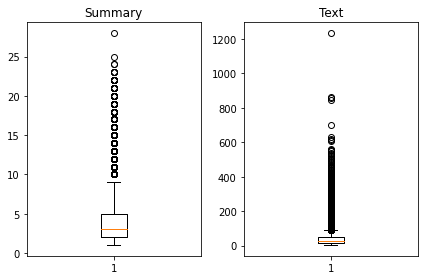

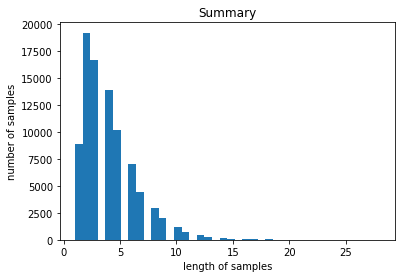

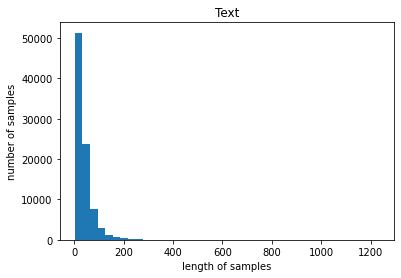

In [36]:
text_len = [ len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이: {} ' .format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 텍스트
  - 대체로 100 이하의 길이
  - 평균길이 38
- 요약
  - 대체로 15 이하의 길이
  - 평균길이 4


### 8) 패딩

In [37]:
# 패딩길이를 각각 60과 8로 정함
text_max_len = 60
summary_max_len = 8

In [38]:
def below_threshold_len(max_len, nested_list) :
  cnt = 0
  for s in nested_list:
    if len(s.split()) <= max_len :
      cnt += 1
  
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %.5f' %(max_len,
                                          (cnt / len(nested_list))))

In [39]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.83533


In [40]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.94246


- 정해진 패딩보다 큰 샘플들을 제거

In [41]:
data = data[data['Text'].apply(lambda x : len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x : len(x.split()) <= summary_max_len)]

print('전체 샘플 수: ' , len(data))

전체 샘플 수:  70761


In [42]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


### 9) seq2seq를 위해 디코더에 시작토큰, 종료토큰 추가

In [43]:
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken ' + x + ' eostoken')

data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,sostoken good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised eostoken
2,confection around centuries light pillowy citr...,sostoken delight says it all eostoken
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken


In [44]:
text_data = list(data['Text'])
summary_data = list(data['Summary'])

### 10) 데이터 분리

In [45]:
X_train, X_test, y_train, y_test = train_test_split(text_data, summary_data,
                                                    test_size = .2,
                                                    random_state = 2046,
                                                    shuffle = True)

len(X_train), len(y_train), len(X_test), len(y_test)

(56608, 56608, 14153, 14153)

### 11) 정수인코딩

#### (1) X Data

In [46]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

- 등장빈도수가 낮은 단어들 배제

In [47]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 34925
등장 빈도가 7번 이하인 희귀 단어의 수: 25866
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9059
단어 집합에서 희귀 단어의 비율: 74.06156048675734
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1506456395233626


- 희귀단어들은 단어 집합에서 46%를 차지하지만, 실제 등장빈도로 차지하는 비중은 3.23%로 매우 낮음

In [48]:
src_vocab = 9000

src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(X_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
X_train = src_tokenizer.texts_to_sequences(X_train)
X_test = src_tokenizer.texts_to_sequences(X_test)

In [49]:
print(X_train[:5])

[[98, 24, 36, 202, 403, 309, 434, 302, 21, 482, 1132, 99, 2, 19], [197, 50, 113, 51, 1232, 8, 548, 744, 1096, 2293], [7, 1036, 1232, 2607, 77, 38, 22, 1036, 7458, 4050, 292, 376, 1376, 3, 652, 2380, 231, 227, 1768], [11, 244, 747, 4, 561, 41, 40, 158, 1394, 790, 125, 78, 43, 226, 26, 561, 1103, 2878, 3772, 388, 4757, 3662, 4435, 11, 42, 228, 19, 112, 162, 147, 622, 821, 262, 147, 10, 54, 16, 351, 262, 233, 56], [2, 5, 67, 1, 372, 21, 1, 123, 10, 325, 123, 10, 7, 73, 290, 1282, 109, 1069, 361, 6, 1118, 222, 19, 5, 325]]


#### (2) y Data

In [51]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

In [55]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11047
등장 빈도가 5번 이하인 희귀 단어의 수: 8159
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2888
단어 집합에서 희귀 단어의 비율: 73.85715578890196
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.057406610752256


In [56]:
tar_vocab = 2500

tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train) 
y_test = tar_tokenizer.texts_to_sequences(y_test)

In [57]:
y_train

[[1, 6, 160, 85, 174, 2],
 [1, 3, 26, 2],
 [1, 42, 2],
 [1, 167, 20, 2],
 [1, 458, 593, 2],
 [1, 925, 168, 22, 118, 2],
 [1, 223, 9, 6, 22, 61, 2],
 [1, 27, 2],
 [1, 1389, 508, 837, 130, 2],
 [1, 3, 60, 2],
 [1, 3, 494, 108, 2],
 [1, 373, 2],
 [1, 926, 4, 13, 2],
 [1, 366, 410, 1477, 2],
 [1, 10, 15, 101, 2],
 [1, 1011, 1012, 338, 61, 386, 2],
 [1, 6, 476, 2],
 [1, 54, 2],
 [1, 21, 520, 26, 2],
 [1, 12, 19, 48, 264, 2263, 23, 1013, 1773, 2],
 [1, 3, 16, 2],
 [1, 469, 88, 984, 949, 2],
 [1, 73, 18, 5, 31, 2],
 [1, 403, 2],
 [1, 6, 43, 4, 26, 43, 1014, 7, 2],
 [1, 3, 38, 2],
 [1, 3, 1253, 18, 403, 1086, 320, 1774, 59, 2],
 [1, 1775, 360, 2],
 [1, 4, 20, 2],
 [1, 927, 2],
 [1, 1137, 3, 31, 2],
 [1, 42, 2],
 [1, 211, 34, 321, 95, 2],
 [1, 8, 341, 14, 2],
 [1, 1254, 818, 2],
 [1, 109, 97, 44, 1645, 2],
 [1, 9, 5, 270, 2],
 [1, 2],
 [1, 5, 8, 145, 138, 2],
 [1, 2264, 271, 2],
 [1, 11, 339, 1776, 37, 12, 2],
 [1, 107, 192, 4, 7, 2],
 [1, 3, 7, 159, 286, 2],
 [1, 10, 15, 2],
 [1, 3, 101, 21, 3

- 빈 샘플 제거

In [58]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

In [59]:
print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 56608
훈련 레이블의 개수 : 56608
테스트 데이터의 개수 : 14153
테스트 레이블의 개수 : 14153


In [ ]:
# 삭제 후 개수

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

In [62]:
print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 55466
훈련 레이블의 개수 : 55466
테스트 데이터의 개수 : 13846
테스트 레이블의 개수 : 13846


### 12) 패딩하기

In [63]:
X_train = pad_sequences(X_train, maxlen = text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')

## 3. Modeling
- seq2seq + attention으로 요약모델 설계 및 훈련

### 1) Encoder, Decoder 설계

In [64]:
embedding_dim = 64
hidden_size = 128

# 인코더
encoder_inputs = Input(shape = (text_max_len, ))

# 인코더의 임베딩 층
encoder_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM1
encoder_lstm1 = LSTM(hidden_size,
                     return_sequences = True,
                     return_state = True,
                     dropout = 0.5,
                     recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

# 인코더의 LSTM2
encoder_lstm2 = LSTM(hidden_size,
                     return_sequences = True,
                     return_state = True,
                     dropout = 0.5,
                     recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM3
encoder_lstm3 = LSTM(hidden_size,
                     return_state = True,
                     return_sequences = True,
                     dropout = 0.5,
                     recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [65]:
# 디코더
decoder_inputs = Input(shape = (None, ))

# 디코더의 임베딩 층
decoder_emb_layer = Embedding(tar_vocab, embedding_dim)
decoder_emb = decoder_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size,
                    return_sequences = True,
                    return_state = True,
                    dropout = 0.5,
                    recurrent_dropout = 0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_emb,
                                    initial_state = [state_h, state_c])

In [66]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

### 2) Model Define

In [67]:
model = Model([encoder_inputs, decoder_inputs],
              decoder_softmax_outputs)

In [68]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 64)       576000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 128), (N 98816       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3) Attention을 이용해 디코더 출력층 설계

In [69]:
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs,
                                    decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1,
                                   name = 'concat_layer')([decoder_outputs,
                                                           attn_out])
                                   
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [70]:
model = Model([encoder_inputs, decoder_inputs],
              decoder_softmax_outputs)

In [71]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 64)       576000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 128), (N 98816       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [72]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'rmsprop')

In [73]:
es = EarlyStopping(monitor = 'val_loss' ,
                   mode = 'min' ,
                   verbose = 1,
                   patience = 2)

In [74]:
%%time

history = model.fit([X_train, y_train[:,:-1]],
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
                    epochs = 10,
                    callbacks = [es],
                    batch_size = 256,
                    validation_data = ([X_test, y_test[:, :-1]],
                                       y_test.reshape(y_test.shape[0],
                                                      y_test.shape[1], 1)[:, 1:]))

Epoch 1/10
217/217 [==============================] - 556s 2s/step - loss: 3.7955 - val_loss: 2.9103
Epoch 2/10
217/217 [==============================] - 541s 2s/step - loss: 2.9167 - val_loss: 2.7976
Epoch 3/10
217/217 [==============================] - 541s 2s/step - loss: 2.7952 - val_loss: 2.7005
Epoch 4/10
217/217 [==============================] - 541s 2s/step - loss: 2.7173 - val_loss: 2.6131
Epoch 5/10
217/217 [==============================] - 542s 2s/step - loss: 2.6340 - val_loss: 2.5416
Epoch 6/10
217/217 [==============================] - 542s 2s/step - loss: 2.5432 - val_loss: 2.4746
Epoch 7/10
217/217 [==============================] - 543s 3s/step - loss: 2.4877 - val_loss: 2.4312
Epoch 8/10
217/217 [==============================] - 542s 2s/step - loss: 2.4195 - val_loss: 2.3915
Epoch 9/10
217/217 [==============================] - 543s 3s/step - loss: 2.3742 - val_loss: 2.3609
Epoch 10/10
217/217 [==============================] - 541s 2s/step - loss: 2.3317 - val_lo

### 4) 학습내용 시각화

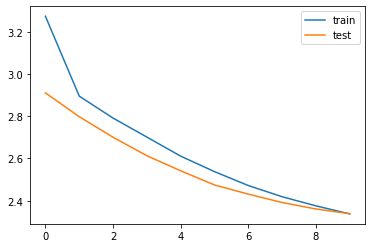

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 4. 모델 테스트
- 테스트를 위해 필요한 사전 3개 생성

In [76]:
src_index_to_word = src_tokenizer.index_word  # 원문 단어집합에서 정수 -> 단어 얻음
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어집학합에서 단어 -> 정수 얻음
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어집합에서 정수 -> 단어 얻음

### 1) 테스트 모델 설계
- 인코더 설계

In [91]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs,
                      outputs=[encoder_outputs, state_h, state_c])

- 디코더 설계

In [94]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

decoder_emb2 = decoder_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음

decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    decoder_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [95]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input,
                                            decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2,
                                                          attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- 테스트를 위해 사용되는 함수 decode_sequence를 설계

In [99]:
def decode_sequence(input_seq) :
  # 입력으로부터 인코더의 상태를 얻음
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  # <sos>에 해당하는 토큰 생성
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = tar_word_to_index['sostoken']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition :
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = tar_index_to_word[sampled_token_index]

    if (sampled_token != 'eostoken') :
      decoded_sentence += ' ' + sampled_token

    # <eos>에 도달하거나 최대 길이를 넘으면 중단
    if (sampled_token == 'eostoken' or
        len(decoded_sentence.split()) >= (summary_max_len -1 )) :

        stop_condition = True
    
    # 길이가 1인 타겟 시퀀스를 업데이트
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sampled_token_index

    # 상태 업데이트
    e_h , e_c = h, c

  return decoded_sentence

- 정수 시퀀스를 텍스트 시퀀스로 만드는 함수 설계

In [97]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq) :
  temp = ''
  for i in input_seq:
    if (i != 0):
      temp = temp + src_index_to_word[i] + ' '
  return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq) :
  temp = ''
  for i in input_seq:
    if ((i != 0 and i != tar_word_to_index['sostoken'])
    and i != tar_word_to_index['eostoken']) :
      temp = temp + tar_index_to_word[i] + ' '

  return temp

- 500번부터 1000번까지 테스트

In [101]:
for i in range(100) :
  print("원문: " , seq2text(X_test[i]))
  print("실제 요약문: " , seq2summary(y_test[i]))
  print("예측 요약문: " , decode_sequence(X_test[i].reshape(1, text_max_len)))
  print("\n")

원문:  great addition diet filling opinion better wider miracle noodles 
실제 요약문:  excellent 
예측 요약문:   great


원문:  shipped fast great product dog teeth giving poodle greenies years vet said teeth white healthy year old dogs years old 
실제 요약문:  greenies 
예측 요약문:   great product


원문:  little candies really exactly say good way wake prefer mocha mint flavor though others good well leave sour taste stomach like coffee keep anywhere desk car pocket purse would without 
실제 요약문:  great product 
예측 요약문:   great product


원문:  eat homemade cooked food saw could feed raw grain free diet easily really thought good true true love smells wonderful costs less half spending making food thanks customers life 
실제 요약문:  my dogs loved it 
예측 요약문:   great product


원문:  love hot spicy taste wasabi peas decided try luck ordering amazon well disappointed peas hot crunchy want snack shipping fast paying oz pack little things target decided better price somewhere well found looking soon finish lb bag back ord

# 5. Model Save

In [102]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
model.save('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/models/004_attention')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/models/004_attention/assets


In [105]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/Natural_Language_Processing/models/

total 175272
-rw------- 1 root root  27219676 Mar 27 11:57 001_word2vec_eng
-rw------- 1 root root  19337305 Mar 31 02:34 002_word2vec_kor_movie
-rw------- 1 root root 117857932 Mar 31 06:08 003_word2vec_kor_wiki
-rw------- 1 root root  15062224 Apr  2 07:01 004_attention.h5


In [110]:
model_google = load_model('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/models/004_attention')

In [111]:
model_google.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 64)       576000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 128), (N 98816       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________